In [1]:
# Copyright 2020 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# AI Explanations: Deploying an image model

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/ml-on-gcp/blob/master/tutorials/explanations/ai-explanations-image.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"> Run in Colab
    </a>
  </td>
  <td>
    <a href="https://github.com/GoogleCloudPlatform/ml-on-gcp/tree/master/tutorials/explanations/ai-explanations-image.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
</table>

## Overview

This tutorial shows how to train a Keras classification model on image data and deploy it to the AI Platform Explanations service to get feature attributions on your deployed model.

If you've already got a trained model and want to deploy it to AI Explanations, skip to the **Export the model as a TF 2 SavedModel** section.

### Dataset

The dataset used for this tutorial is the [flowers dataset](https://www.tensorflow.org/datasets/catalog/tf_flowers) from [TensorFlow Datasets](https://www.tensorflow.org/datasets/catalog/overview).

### Objective

The goal of this tutorial is to train a model on a simple image dataset (flower classification) to understand how you can use AI Explanations with image models. For image models, AI Explanations returns an image with the pixels highlighted that signaled your model's prediction the most.

This tutorial focuses more on deploying the model to AI Platform with Explanations than on the design of the model itself. 

### Costs

This tutorial uses billable components of Google Cloud Platform (GCP):

* AI Platform for:
  * Prediction
  * Explanation: AI Explanations comes at no extra charge to prediction prices. However, explanation requests take longer to process than normal predictions, so heavy usage of Explanations along with auto-scaling may result in more nodes being started and thus more charges
* Cloud Storage for:
  * Storing model files for deploying to Cloud AI Platform

Learn about [AI Platform
pricing](https://cloud.google.com/ml-engine/docs/pricing) and [Cloud Storage
pricing](https://cloud.google.com/storage/pricing), and use the [Pricing
Calculator](https://cloud.google.com/products/calculator/)
to generate a cost estimate based on your projected usage.

## Before you begin

**Make sure you're running this notebook in a GPU runtime if you have that option. In Colab, select Runtime --> Change runtime type**



This tutorial assumes you are running the notebook either in **Colab** or **Cloud AI Platform Notebooks**.

### Set up your GCP project

**The following steps are required, regardless of your notebook environment.**

1. [Select or create a GCP project.](https://console.cloud.google.com/cloud-resource-manager)

2. [Make sure that billing is enabled for your project.](https://cloud.google.com/billing/docs/how-to/modify-project)

3. [Enable the AI Platform Training & Prediction and Compute Engine APIs.](https://console.cloud.google.com/flows/enableapi?apiid=ml.googleapis.com,compute_component)

4. Enter your project ID in the cell below. Then run the  cell to make sure the
Cloud SDK uses the right project for all the commands in this notebook.

**Note**: Jupyter runs lines prefixed with `!` as shell commands, and it interpolates Python variables prefixed with `$` into these commands.

#### Project ID

**If you don't know your project ID.**

You maybe able to get your PROJECT_ID using gcloud.

In [2]:
# Get your GCP project id from gcloud
shell_output=!gcloud config list --format 'value(core.project)' 2>/dev/null
PROJECT_ID=shell_output[0]
print("Project ID:", PROJECT_ID)

Project ID: andy-1234-221921


Otherwise, set your project id here.

In [3]:
if PROJECT_ID == "" or PROJECT_ID is None:
    PROJECT_ID = "[your-project-id]" #@param {type:"string"}

#### Region

You may also change the `REGION` variable, which is used for operations
throughout the rest of this notebook. Make sure to [choose a region where Cloud
AI Platform services are
available](https://cloud.google.com/ml-engine/docs/tensorflow/regions). You may
not use a Multi-Regional Storage bucket for training with AI Platform.

In [4]:
REGION = 'us-central1' #@param {type: "string"}

#### Timestamp

If you are in a live tutorial session, you may be using a shared test account or project. To avoid name collisions between users on resources created, we create a timestamp for each instance session, and append onto the name of resources which will be created in this tutorial.

In [5]:
from datetime import datetime

TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")

### Authenticate your GCP account

**If you are using AI Platform Notebooks**, your environment is already
authenticated. Skip this step.

**If you are using Colab**, run the cell below and follow the instructions
when prompted to authenticate your account via oAuth.

In [6]:
import sys, os

# If you are running this notebook in Colab, run this cell and follow the
# instructions to authenticate your Google Cloud account. This provides access
# to your Cloud Storage bucket and lets you submit training jobs and prediction
# requests.

# If on AI Platform, then don't execute this code
if not os.path.exists('/opt/deeplearning/metadata/env_version'):
    if 'google.colab' in sys.modules:
        from google.colab import auth as google_auth
        google_auth.authenticate_user()

    # If you are running this tutorial in a notebook locally, replace the string
    # below with the path to your service account key and run this cell to
    # authenticate your Google Cloud account.
    else:
        %env GOOGLE_APPLICATION_CREDENTIALS your_path_to_credentials.json

    # Log in to your account on Google Cloud
    ! gcloud auth login

### Alpha Users

For alpha users, you need to tell AI Platform to use the alpha version of the python SDK.

In [ ]:
!gcloud config set project $PROJECT_ID
# Need this to use alpha endpoint (alpha-ml.googleapis)
import os
endpoint = "https://alpha-ml.googleapis.com/"
os.environ["CLOUDSDK_API_ENDPOINT_OVERRIDES_ML"] = endpoint

### Create a Cloud Storage bucket

**The following steps are required, regardless of your notebook environment.**

When you submit a training job using the Cloud SDK, you upload a Python package
containing your training code to a Cloud Storage bucket. AI Platform runs
the code from this package. In this tutorial, AI Platform also saves the
trained model that results from your job in the same bucket. You can then
create an AI Platform model version based on this output in order to serve
online predictions.

Set the name of your Cloud Storage bucket below. It must be unique across all
Cloud Storage buckets. 

In [7]:
BUCKET_NAME = PROJECT_ID + "_xai_flowers_" + TIMESTAMP

**Only if your bucket doesn't already exist**: Run the following cell to create your Cloud Storage bucket.

In [8]:
! gsutil mb -l $REGION gs://$BUCKET_NAME

Creating gs://andy-1234-221921_xai_flowers_20200817221203/...


### Import libraries

Import the libraries we'll be using in this tutorial. This tutorial has been tested with **TensorFlow versions 2.1 and 2.2**.

In [9]:
import math, json, random
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_hub as hub

from matplotlib import pyplot as plt
from base64 import b64encode

# should be >= 2.1
print("Tensorflow version " + tf.__version__)
if tf.__version__ < "2.1":
    raise Exception("TF 2.1 or greater is required")

AUTO = tf.data.experimental.AUTOTUNE
print("AUTO", AUTO)

Tensorflow version 2.2.0
AUTO -1


## Downloading and preprocessing the flowers dataset

In this section you'll download the flower images (in this dataset they are `TFRecords`), use the `tf.data` API to create a data input pipeline, and split the data into training and validation sets.

In [10]:
GCS_PATTERN = 'gs://flowers-public/tfrecords-jpeg-192x192-2/*.tfrec'
IMAGE_SIZE = [192, 192]

BATCH_SIZE = 32 

VALIDATION_SPLIT = 0.19
CLASSES = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'] # do not change, maps to the labels in the data (folder names)

# Split data files between training and validation
filenames = tf.io.gfile.glob(GCS_PATTERN)
random.shuffle(filenames)
split = int(len(filenames) * VALIDATION_SPLIT)
training_filenames = filenames[split:]
validation_filenames = filenames[:split]
print("Pattern matches {} data files. Splitting dataset into {} training files and {} validation files".format(len(filenames), len(training_filenames), len(validation_filenames)))
validation_steps = int(3670 // len(filenames) * len(validation_filenames)) // BATCH_SIZE
steps_per_epoch = int(3670 // len(filenames) * len(training_filenames)) // BATCH_SIZE
print("With a batch size of {}, there will be {} batches per training epoch and {} batch(es) per validation run.".format(BATCH_SIZE, steps_per_epoch, validation_steps))

Pattern matches 16 data files. Splitting dataset into 13 training files and 3 validation files
With a batch size of 32, there will be 93 batches per training epoch and 21 batch(es) per validation run.


The following cell contains some image visualization utility functions. This code isn't essential to training or deploying the model. 

If you're running this from Colab the cell is hidden. You can look at the code by right clicking on the cell --> "Form" --> "Show form" if you'd like to see it.

In [11]:
#@title display utilities [RUN ME]

def dataset_to_numpy_util(dataset, N):
  dataset = dataset.batch(N)
  
  if tf.executing_eagerly():
    # In eager mode, iterate in the Datset directly.
    for images, labels in dataset:
      numpy_images = images.numpy()
      numpy_labels = labels.numpy()
      break;
      
  else: # In non-eager mode, must get the TF note that 
        # yields the nextitem and run it in a tf.Session.
    get_next_item = dataset.make_one_shot_iterator().get_next()
    with tf.Session() as ses:
      numpy_images, numpy_labels = ses.run(get_next_item)

  return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
  label = np.argmax(label, axis=-1)  # one-hot to class number
  correct_label = np.argmax(correct_label, axis=-1) # one-hot to class number
  correct = (label == correct_label)
  return "{} [{}{}{}]".format(CLASSES[label], str(correct), ', shoud be ' if not correct else '',
                              CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=16, color='red' if red else 'black')
    return subplot+1
  
def display_9_images_from_dataset(dataset):
  subplot=331
  plt.figure(figsize=(13,13))
  images, labels = dataset_to_numpy_util(dataset, 9)
  for i, image in enumerate(images):
    title = CLASSES[np.argmax(labels[i], axis=-1)]
    subplot = display_one_flower(image, title, subplot)
    if i >= 8:
      break;
              
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()
  
def display_9_images_with_predictions(images, predictions, labels):
  subplot=331
  plt.figure(figsize=(13,13))
  for i, image in enumerate(images):
    title, correct = title_from_label_and_target(predictions[i], labels[i])
    subplot = display_one_flower(image, title, subplot, not correct)
    if i >= 8:
      break;
              
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()
  
def display_training_curves(training, validation, title, subplot):
  if subplot%10==1: # set up the subplots on the first call
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
    plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.set_facecolor('#F8F8F8')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])

### Read images and labels from TFRecords

In [12]:
def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means scalar
        "one_hot_class": tf.io.VarLenFeature(tf.float32),
    }
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size will be needed for TPU
    class_label = tf.cast(example['class'], tf.int32)
    one_hot_class = tf.sparse.to_dense(example['one_hot_class'])
    one_hot_class = tf.reshape(one_hot_class, [5])
    return image, one_hot_class

def load_dataset(filenames):
  # Read data from TFRecords

  dataset = tf.data.Dataset.from_tensor_slices(filenames)
  dataset = dataset.interleave(tf.data.TFRecordDataset, cycle_length=16, num_parallel_calls=AUTO) # faster
  dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
  return dataset

In the following cell, we'll use a visualization utility function we defined above to preview some flower images with their associated labels.

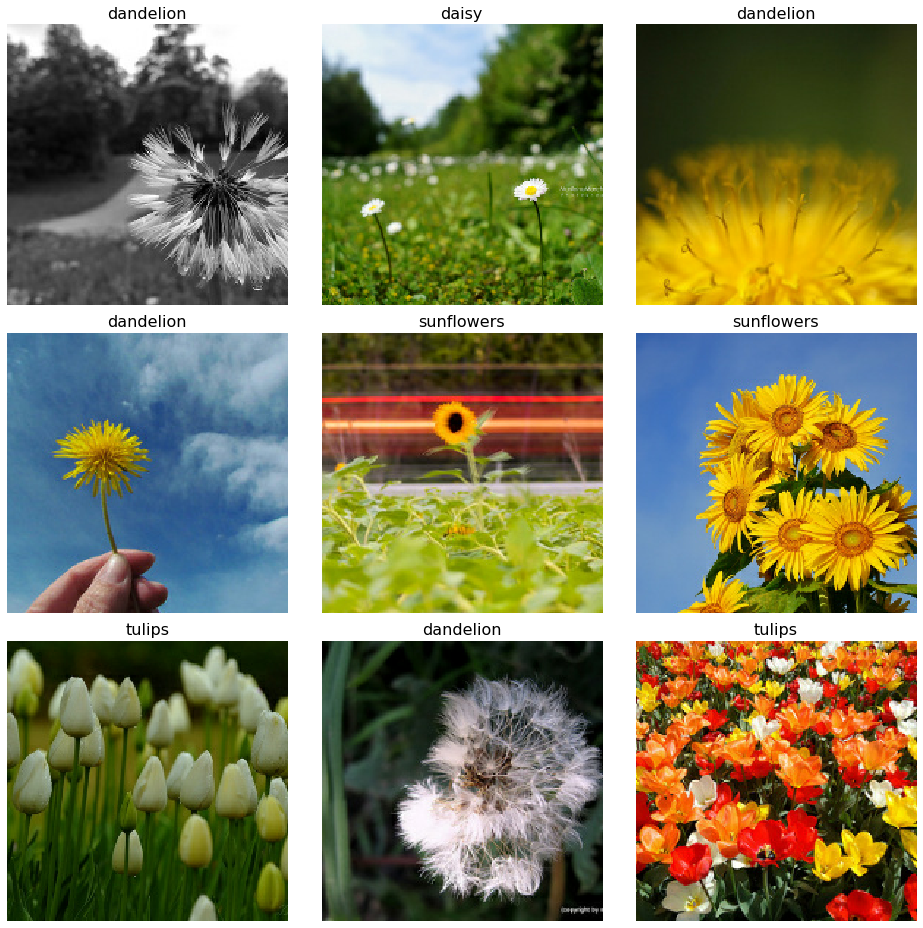

In [13]:
display_9_images_from_dataset(load_dataset(training_filenames))

### Create training and validation datasets

In [14]:
def get_batched_dataset(filenames):
  dataset = load_dataset(filenames)
  dataset = dataset.cache() # This dataset fits in RAM
  dataset = dataset.repeat()
  dataset = dataset.shuffle(2048)
  dataset = dataset.batch(BATCH_SIZE)
  dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
  # For proper ordering of map/batch/repeat/prefetch, see Dataset performance guide: https://www.tensorflow.org/guide/performance/datasets
  return dataset

def get_training_dataset():
  return get_batched_dataset(training_filenames)

def get_validation_dataset():
  return get_batched_dataset(validation_filenames)

some_flowers, some_labels = dataset_to_numpy_util(load_dataset(validation_filenames), 8*20)

## Build, train, and evaluate the model

In this section we'll define the layers of our model using the Keras Sequential model API. Then we'll run training and evaluation, and finally run some test predictions on the local model.


In [15]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, GlobalAveragePooling2D, ReLU, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
REG=0.001

model = tf.keras.Sequential([
    # Stem
    Conv2D(kernel_size=3, filters=16, padding='same', activation='relu', input_shape=[*IMAGE_SIZE, 3]),
    BatchNormalization(),
    Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=2),
    
    # Conv Group
    Conv2D(kernel_size=3, filters=64, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=2),
    Conv2D(kernel_size=3, filters=96, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=2),
    
    # Conv Group
    Conv2D(kernel_size=3, filters=128, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=2),
    Conv2D(kernel_size=3, filters=128, padding='same', activation='relu'),
    BatchNormalization(),
    
    # 1x1 Reduction
    Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    BatchNormalization(),
    
    # Classifier
    GlobalAveragePooling2D(),
    Dense(5, activation='softmax')
])

model.compile(
  optimizer=Adam(lr=0.005, decay=0.98),
  loss= 'categorical_crossentropy',
  metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 192, 192, 16)      448       
_________________________________________________________________
batch_normalization (BatchNo (None, 192, 192, 16)      64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 192, 192, 32)      4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 192, 192, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 96, 96, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 96, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 96, 96, 64)        2

### Train the model

Train this on a GPU if you have access (in Colab, from the menu select **Runtime** --> **Change runtime type**). On a CPU, it'll take ~30 minutes to run training. On a GPU, it takes ~5 minutes.

In [16]:
EPOCHS = 20 # Train for 60 epochs for higher accuracy, 20 should get you ~75%

history = model.fit(get_training_dataset(), steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
                    validation_data=get_validation_dataset(), validation_steps=validation_steps)

Epoch 1/20
93/93 [==============================] - 8s 91ms/step - loss: 1.1678 - accuracy: 0.5464 - val_loss: 2.3203 - val_accuracy: 0.2381
Epoch 2/20
93/93 [==============================] - 7s 80ms/step - loss: 0.9765 - accuracy: 0.6347 - val_loss: 2.4781 - val_accuracy: 0.2560
Epoch 3/20
93/93 [==============================] - 7s 79ms/step - loss: 0.9540 - accuracy: 0.6374 - val_loss: 2.1307 - val_accuracy: 0.2664
Epoch 4/20
93/93 [==============================] - 7s 79ms/step - loss: 0.9243 - accuracy: 0.6610 - val_loss: 1.7430 - val_accuracy: 0.3973
Epoch 5/20
93/93 [==============================] - 7s 78ms/step - loss: 0.9198 - accuracy: 0.6640 - val_loss: 1.3591 - val_accuracy: 0.5312
Epoch 6/20
93/93 [==============================] - 7s 78ms/step - loss: 0.8953 - accuracy: 0.6670 - val_loss: 1.0353 - val_accuracy: 0.6176
Epoch 7/20
93/93 [==============================] - 7s 77ms/step - loss: 0.8944 - accuracy: 0.6680 - val_loss: 0.9281 - val_accuracy: 0.6949
Epoch 8/20
93

### Get predictions on local model and visualize them

In [17]:
# Randomize the input so that you can execute multiple times to change results
permutation = np.random.permutation(8*20)
some_flowers, some_labels = (some_flowers[permutation], some_labels[permutation])

predictions = model.predict(some_flowers, batch_size=16)
evaluations = model.evaluate(some_flowers, some_labels, batch_size=16)
  
print(np.array(CLASSES)[np.argmax(predictions, axis=-1)].tolist())
print('[val_loss, val_acc]', evaluations)

10/10 [==============================] - 0s 8ms/step - loss: 0.9406 - accuracy: 0.6875
['roses', 'tulips', 'dandelion', 'dandelion', 'sunflowers', 'roses', 'sunflowers', 'roses', 'dandelion', 'daisy', 'sunflowers', 'sunflowers', 'roses', 'sunflowers', 'dandelion', 'tulips', 'roses', 'daisy', 'daisy', 'dandelion', 'sunflowers', 'dandelion', 'dandelion', 'dandelion', 'daisy', 'dandelion', 'dandelion', 'tulips', 'daisy', 'tulips', 'dandelion', 'roses', 'daisy', 'dandelion', 'dandelion', 'tulips', 'daisy', 'tulips', 'sunflowers', 'tulips', 'roses', 'roses', 'sunflowers', 'tulips', 'tulips', 'sunflowers', 'daisy', 'daisy', 'dandelion', 'tulips', 'sunflowers', 'dandelion', 'sunflowers', 'daisy', 'dandelion', 'dandelion', 'roses', 'sunflowers', 'tulips', 'dandelion', 'dandelion', 'daisy', 'daisy', 'roses', 'tulips', 'dandelion', 'daisy', 'dandelion', 'tulips', 'sunflowers', 'daisy', 'daisy', 'tulips', 'dandelion', 'sunflowers', 'dandelion', 'roses', 'tulips', 'sunflowers', 'dandelion', 'dande

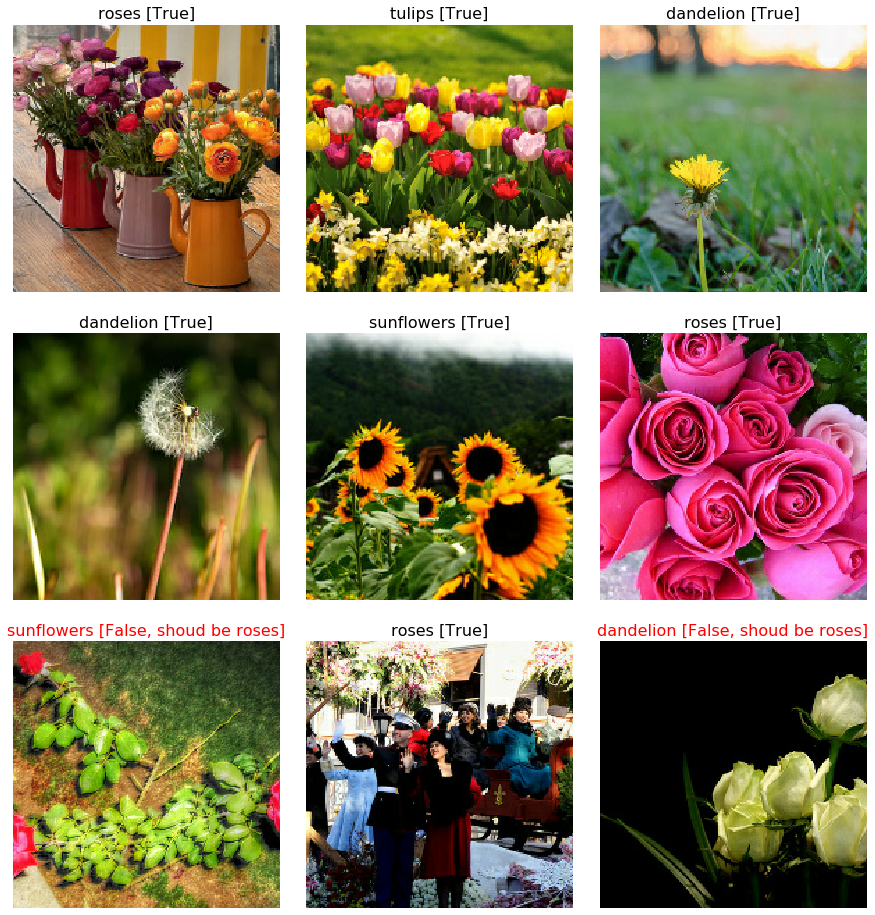

In [18]:
display_9_images_with_predictions(some_flowers, predictions, some_labels)

## Export the model as a TF 2 SavedModel

For TF2.x, we save the model in TF SavedModel format and load it into GCS. We are also adding a serving function so we can send the image data during prediction as base 64 encoded and the serving function will decode back to raw numpy bytes.

### Serving Function

For inference, we will send our image data in base 64 encoding (b64), which is more space efficient. The input to the model though is raw bytes. That means on the model serving side, we need to convert the b64 data back into raw bytes before passing it on to the deployed model.

We do this by defining a serving function (serving_fn) which we attach to the model as a preprocessing step. We add @tf.function decorator so the serving function is part of the model's graph (instead of upstream on a CPU).

When we do a prediction and explanation, the request will go the serving function, which will preprocess the b64 bytes into raw (numpy) bytes, which is then passed as input to the model.

In [19]:
export_path = 'gs://' + BUCKET_NAME + '/explanations/mymodel'

def _preprocess(bytes_input):
    decoded = tf.io.decode_jpeg(bytes_input, channels=3)
    decoded = tf.image.convert_image_dtype(decoded, tf.float32)
    resized = tf.image.resize(decoded, size=(192, 192))
    return resized

@tf.function(input_signature=[tf.TensorSpec([None], tf.string)])
def preprocess_fn(bytes_inputs):
    decoded_images = tf.map_fn(_preprocess, bytes_inputs, dtype=tf.float32, back_prop=False)
    return {"numpy_inputs": decoded_images} # User needs to make sure the key matches model's input

m_call = tf.function(model.call).get_concrete_function([tf.TensorSpec(shape=[None, 192, 192, 3], dtype=tf.float32, name="numpy_inputs")])

@tf.function(input_signature=[tf.TensorSpec([None], tf.string)])
def serving_fn(bytes_inputs):
    images = preprocess_fn(bytes_inputs)
    prob = m_call(**images)
    return prob
  
tf.saved_model.save(model, export_path, signatures={
    'serving_default': serving_fn,
    'xai_preprocess': preprocess_fn, # Required for XAI
    'xai_model': m_call # Required for XAI
    })  

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.map_fn(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(fn, elems))
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: gs://andy-1234-221921_xai_flowers_20200817221203/explanations/mymodel/assets


## Model Input/Ouput Signatures

Use TensorFlow's `saved_model_cli` to inspect the model's SignatureDef. We'll use this information when we deploy our model to AI Explanations in the next section.

In [20]:
!saved_model_cli show --dir $export_path --all

Error processing line 1 of /home/jupyter/.local/lib/python3.7/site-packages/google-cloud-aiplatform-nspkg.pth:

  Traceback (most recent call last):
    File "/opt/conda/lib/python3.7/site.py", line 168, in addpackage
      exec(line)
    File "<string>", line 1, in <module>
    File "<frozen importlib._bootstrap>", line 580, in module_from_spec
  AttributeError: 'NoneType' object has no attribute 'loader'

Remainder of file ignored
Error processing line 1 of /opt/conda/lib/python3.7/site-packages/google-cloud-aiplatform-nspkg.pth:

  Traceback (most recent call last):
    File "/opt/conda/lib/python3.7/site.py", line 168, in addpackage
      exec(line)
    File "<string>", line 1, in <module>
    File "<frozen importlib._bootstrap>", line 580, in module_from_spec
  AttributeError: 'NoneType' object has no attribute 'loader'

Remainder of file ignored

MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedMode

### Get Signatures

In this cell, we will programatically get the signatures of the layers for:

- Serving Function input layer
- Model input layer
- Model output layer

We will do this by reloading the model into memory, and query it for the corresponding signatures.

In [21]:
loaded = tf.saved_model.load(export_path)

input_name = list(loaded.signatures['xai_model'].structured_input_signature[1].keys())[0]
print(input_name)

output_name = list(loaded.signatures['xai_model'].structured_outputs.keys())[0]
print(output_name)

preprocess_name = list(loaded.signatures['xai_preprocess'].structured_input_signature[1].keys())[0]
print(preprocess_name)

numpy_inputs
output_0
bytes_inputs


## Generate the metadata for AI Explanations

In order to deploy this model to Cloud Explanations, we need to create an `explanation_metadata.json` file with information about our model inputs, outputs, and baseline. 

For image models, using `[0,1]` as your input baseline represents black and white images. In this case we're using `np.random` to generate the baseline because our training images contain a lot of black and white (i.e. daisy petals).

*Note*, for the explanation request, how we use the model's (and not serving function) signature for the input and output tensors.

In [22]:
random_baseline = np.random.rand(192,192,3)

In [23]:
explanation_metadata = {
    "inputs": {
      "data": {
        "input_tensor_name": input_name,
        "modality": "image",
        "input_baselines": [random_baseline.tolist()]
      }
    },
    "outputs": {
      "probability": {
        "output_tensor_name": output_name
      }
    },
  "framework": "tensorflow"
  }

In [24]:
# Write the json to a local file
with open('explanation_metadata.json', 'w') as output_file:
  json.dump(explanation_metadata, output_file)

In [25]:
# Copy this file into the GCS location with our SavedModel assets
!gsutil cp explanation_metadata.json $export_path

Copying file://explanation_metadata.json [Content-Type=application/json]...
/ [1 files][  2.2 MiB/  2.2 MiB]                                                
Operation completed over 1 objects/2.2 MiB.                                      


## Deploy model to AI Explanations

In this step we'll use the `gcloud` CLI to deploy our model to AI Explanations.

### Create the model

In [26]:
import datetime
MODEL = 'flowers' + TIMESTAMP
print(MODEL)

flowers20200817221203


In [27]:
# Create the model if it doesn't exist yet (you only need to run this once)
!gcloud ai-platform models create $MODEL --enable-logging --regions=us-central1

Created ml engine model [projects/andy-1234-221921/models/flowers20200817221203].


### Create explainable model versions

For image models, we offer two choices for explanation methods: 
* Integrated Gradients (IG)
* XRAI 

You can find more info on each method in the [documentation](TODO). Below, we'll show you how to deploy a version with both so that you can compare results. **If you already know which explanation method you'd like to use, you can deploy one version and skip the code blocks for the other method.**

Creating the version will take ~5-10 minutes. Note that your first deploy may take longer.

#### Deploy an explainable model with Integrated Gradients

In [28]:
# Each time you create a version the name should be unique
IG_VERSION = 'v_ig'

In [29]:
!gcloud beta ai-platform versions create $IG_VERSION \
--model $MODEL \
--origin $export_path \
--runtime-version 2.1 \
--framework TENSORFLOW \
--python-version 3.7 \
--machine-type n1-standard-4 \
--explanation-method integrated-gradients \
--num-integral-steps 25

Explanations reflect patterns in your model, but don't necessarily reveal fundamental relationships about your data population. See https://cloud.google.com/ml-engine/docs/ai-explanations/limitations for more information.
Creating version (this might take a few minutes)......done.                    


In [30]:
# Make sure the IG model deployed correctly. State should be `READY` in the following log
!gcloud ai-platform versions describe $IG_VERSION --model $MODEL

createTime: '2020-08-17T22:24:48Z'
deploymentUri: gs://andy-1234-221921_xai_flowers_20200817221203/explanations/mymodel
etag: 4MBvxVu8L9I=
explanationConfig:
  integratedGradientsAttribution:
    numIntegralSteps: 25
framework: TENSORFLOW
isDefault: true
machineType: n1-standard-4
name: projects/andy-1234-221921/models/flowers20200817221203/versions/v_ig
pythonVersion: '3.7'
runtimeVersion: '2.1'
state: READY


#### Deploy an explainable model with XRAI

In [31]:
# Each time you create a version the name should be unique
XRAI_VERSION = 'v_xrai'

In [32]:
# Create the XRAI version with gcloud
!gcloud beta ai-platform versions create $XRAI_VERSION \
--model $MODEL \
--origin $export_path \
--runtime-version 2.1 \
--framework TENSORFLOW \
--python-version 3.7 \
--machine-type n1-standard-4 \
--explanation-method xrai \
--num-integral-steps 25

Explanations reflect patterns in your model, but don't necessarily reveal fundamental relationships about your data population. See https://cloud.google.com/ml-engine/docs/ai-explanations/limitations for more information.
Creating version (this might take a few minutes)......done.                    


In [33]:
# Make sure the XRAI model deployed correctly. State should be `READY` in the following log
!gcloud ai-platform versions describe $XRAI_VERSION --model $MODEL

createTime: '2020-08-17T22:26:49Z'
deploymentUri: gs://andy-1234-221921_xai_flowers_20200817221203/explanations/mymodel
etag: qV7U6baaoEw=
explanationConfig:
  xraiAttribution:
    numIntegralSteps: 25
framework: TENSORFLOW
machineType: n1-standard-4
name: projects/andy-1234-221921/models/flowers20200817221203/versions/v_xrai
pythonVersion: '3.7'
runtimeVersion: '2.1'
state: READY


## Get predictions and explanations on deployed model

Here we'll prepare some test images to send to our model. Then we'll use the AI Platform Prediction API to get the model's predicted class along with the explanation for each image.

### Get and Prepare Test Images

First, we will:

- Download from a public GCS a small sample of images from the flowers dataset -- just enough for a batch prediction.
- Resize the images to match the input shape (192, 192) of the model.
- Save the resized images back to your bucket.

In [34]:
# Download test flowers from public bucket
!mkdir flowers
!gsutil -m cp gs://flowers_model/test_flowers/* ./flowers

mkdir: cannot create directory ‘flowers’: File exists
Copying gs://flowers_model/test_flowers/daisy.jpeg...
Copying gs://flowers_model/test_flowers/dandelion.jpg...
Copying gs://flowers_model/test_flowers/tulip.jpg...


In [35]:
# Resize the images to what our model is expecting (192,192)
test_filenames = []

for i in os.listdir('flowers'):
  img_path = 'flowers/' + i
  with PIL.Image.open(img_path) as ex_img:
    resize_img = ex_img.resize([192,192])
    resize_img.save(img_path)
    test_filenames.append(img_path)

### Construct the Batch Prediction request

Prepare the prediction batch request in JSONL format.

In [36]:
# Prepare our prediction JSON to send to our Cloud model
instances = []

for image_path in test_filenames:
    img_bytes = tf.io.read_file(image_path)
    b64str = b64encode(img_bytes.numpy()).decode('utf-8')
    instances.append({preprocess_name: {'b64': b64str}})

Save the instances (batch) as a JSONL file.

In [37]:
with open('predict.json', 'w') as outfile:
  for instance in instances:
    json.dump(instance, outfile)
    outfile.write('\n')

### Make an AI Explanations request with gcloud

First we'll look at the explanations results for IG, then we'll compare with XRAI. 

The `gcloud` below calls our deployed model with the specified image data, model name, and version.

**If you only deployed one model above, run only the cell for that explanation method.**

In [ ]:
# IG EXPLANATIONS
resp_obj = !gcloud beta ai-platform explain --model $MODEL --version $IG_VERSION --json-instances='predict.json' --verbosity=none
ig_response = json.loads(resp_obj.s)
print(ig_response)

In [ ]:
# XRAI EXPLANATIONS
resp_obj = !gcloud beta ai-platform explain --model $MODEL --version $XRAI_VERSION --json-instances='predict.json' --verbosity=none
xrai_response = json.loads(resp_obj.s)
print(xrai_response)

### See our model's predicted classes without explanations

First, let's preview the images and see what our model predicted for them. Why did the model predict these classes? We'll see explanations in the next section.

In [ ]:
from io import BytesIO
import matplotlib.image as mpimg
import base64

# Note: change the `ig_response` variable below if you didn't deploy an IG model
for i,val in enumerate(ig_response['explanations']):
    class_name = CLASSES[val['attributions_by_label'][0]['label_index']]
    confidence_score = str(round(val['attributions_by_label'][0]['example_score'] * 100, 3)) + '%'
    print('Predicted class: ' + class_name + '\n' + 'Confidence score: ' + confidence_score)
    
    b64str = img = instances[i][preprocess_name]['b64']
    i = base64.b64decode(b64str)
    i = BytesIO(i)
    img = mpimg.imread(i, format='JPG')
    
    plt.imshow(img, interpolation='nearest')
    plt.show()

### Visualize the images with AI Explanations

Now let's look at the explanations.  

The images returned show the explanations for **only the top class predicted by the model**. This means that if one of our model's predictions is incorrect, the pixels you see highlighted are for the _incorrect class_. For example, if the model predicted rose when it should have predicted tulip, you'll see explanations for why the model thought this image was a rose.

First, we'll visualize the attributions for our **Integrated Gradients version**. Currently, the highlighted pixels returned from AI Explanations show the top 60% of pixels that contributed to the model's prediction. The pixels we'll see after running the cell below show us the pixels that signaled the model's prediction most.

In [ ]:
import io

for idx, flower in enumerate(ig_response['explanations']):
  predicted_flower = CLASSES[flower['attributions_by_label'][0]['label_index']]
  confidence = flower['attributions_by_label'][0]['example_score']
  print('Predicted flower: ', predicted_flower)
  b64str = flower['attributions_by_label'][0]['attributions']['data']['b64_jpeg']
  i = base64.b64decode(b64str)
  i = io.BytesIO(i)
  i = mpimg.imread(i, format='JPG')

  plt.imshow(i, interpolation='nearest')
  plt.show()

Let's compare this with the image explanations we get from our XRAI version.

In [ ]:
for idx, flower in enumerate(xrai_response['explanations']):
  predicted_flower = CLASSES[flower['attributions_by_label'][0]['label_index']]
  confidence = flower['attributions_by_label'][0]['example_score']
  print('Predicted flower: ', predicted_flower)
  b64str = flower['attributions_by_label'][0]['attributions']['data']['b64_jpeg']
  i = base64.b64decode(b64str)
  i = io.BytesIO(i)
  i = mpimg.imread(i, format='JPG')

  plt.imshow(i, interpolation='nearest')
  plt.show()

In [ ]:
xrai_response

## Sanity check our explanations

To better make sense of the feature attributions we're getting, we should compare them with our model's baseline. In the case of image models, the `baseline_score` returned by AI Explanations is the score our model would give an image input with the baseline we specified. The baseline will be different for each class in our model. In other words, every time your model predicts `tulip` as the top class, you'll see the same baseline score. 

In this case, we used a baseline image of `np.random` randomly generated values. If you'd like the baseline for your model to be solid black and white images instead, pass `[0,1]` as the value to `input_baselines` in your `explanation_metadata.json` file above.

If the `baseline_score` is very close to the value of `example_score`, the highlighted pixels may not be meaningful. 

Below we'll calculate the difference between `baseline_score` and `example_score` for the 3 test images above.

Note that the score values for classification models are _probabilities_: the confidence your model has in its predicted class. A score of 0.90 for tulip means your model has classified the image as a tulip with 90% confidence.

We're running sanity checks below on our IG model, but if you'd like to inspect your XRAI model just swap out the `ig_response` and `IG_VERSION` variables below.

In [ ]:
for i,val in enumerate(ig_response['explanations']):
  baseline_score = val['attributions_by_label'][0]['baseline_score']
  predicted_score = val['attributions_by_label'][0]['example_score']
  print('Baseline score: ', baseline_score) 
  print('Predicted score: ', predicted_score)
  print('Predicted - Baseline: ', predicted_score - baseline_score, '\n')

As another sanity check, we'll also look at the explanations for this model's baseline image: an image array of randomly generated values using `np.random`. First, we'll convert the same `np.random` baseline array we generated above to a base64 string and preview it.

*Note*, we will pretend (and encode) as of this random noise was a PNG image. Also note, we convert the byte buffer to a numpy array, because this is the format the underlying model expects for input when we do the explain request.

In [ ]:
# Convert our baseline from above to a base64 string
rand_test_img = PIL.Image.fromarray((random_baseline * 255).astype('uint8'))
buffer = BytesIO()
rand_test_img.save(buffer, format="PNG")
new_image_string = base64.b64encode(np.asarray(buffer.getvalue())).decode("utf-8")

# Preview it
plt.imshow(rand_test_img)

In [ ]:
# Save the image to a variable in the format our model is expecting
sanity_check_img = {preprocess_name: {'b64': new_image_string}}

with open('predict.json', 'w') as outfile:
  for instance in instances:
    json.dump(sanity_check_img, outfile)
    outfile.write('\n')

### Make Explain Request

In [ ]:
# Sanity Check explanations EXPLANATIONS
resp_obj = !gcloud beta ai-platform explain --model $MODEL --version $IG_VERSION --json-instances='predict.json' --verbosity=none
sanity_check_response = json.loads(resp_obj.s)

### View the Explanations

From the explanation response, let's reconstruct the image and highlight the pixels that contributed to the prediction.

In [ ]:
# View explanations on the baseline random image
sanity_check_img = base64.b64decode(sanity_check_response['explanations'][0]['attributions_by_label'][0]['attributions']['data']['b64_jpeg'])
sanity_check_img = io.BytesIO(sanity_check_img)
sanity_check_img = mpimg.imread(sanity_check_img, format='JPG')

plt.imshow(sanity_check_img, interpolation='nearest')
plt.show()

The difference between your model's predicted score and the baseline score for this image should be close to 0. Run the following cell to confirm. If there is a difference between these two values you may need to increase the number of integral steps used when you deploy your model.

In [ ]:
baseline_score = sanity_check_response['explanations'][0]['attributions_by_label'][0]['baseline_score']
example_score = sanity_check_response['explanations'][0]['attributions_by_label'][0]['example_score']

print(abs(baseline_score - example_score))

## Cleaning up

To clean up all GCP resources used in this project, you can [delete the GCP
project](https://cloud.google.com/resource-manager/docs/creating-managing-projects#shutting_down_projects) you used for the tutorial.

Alternatively, you can clean up individual resources by running the following
commands:

In [ ]:
# Delete model version resource
!gcloud ai-platform versions delete $IG_VERSION --quiet --model $MODEL
!gcloud ai-platform versions delete $XRAI_VERSION --quiet --model $MODEL

# Delete model resource
!gcloud ai-platform models delete $MODEL --quiet

# Delete Cloud Storage objects that were created
!gsutil -m rm -r $BUCKET_NAME

If your Cloud Storage bucket doesn't contain any other objects and you would like to delete it, run `gsutil rm -r gs://$BUCKET_NAME`.

## What's next?

To learn more about AI Explanations, check out the resources here.

* [AI Explanations documentation](https://cloud.google.com/ai-platform/prediction/docs/ai-explanations/overview)
* [AI Explanations whitepaper](https://storage.googleapis.com/cloud-ai-whitepapers/AI%20Explainability%20Whitepaper.pdf)
* [Integrated gradients paper](https://arxiv.org/abs/1703.01365)
* [XRAI paper](https://arxiv.org/abs/1906.02825)